In [2]:
#IMPORT STATEMENTS
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim


# **Transformation of data**

In [3]:
transform=transforms.Compose([
          transforms.Resize((224,224)),
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

# **Load the data**

In [5]:
train_set=ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/train',transform)
test_set =ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform)
val_set =ImageFolder('/kaggle/input/chest-xray-pneumonia/chest_xray/val', transform)

In [6]:
#Load in batches and shuffle the data
test=DataLoader(test_set,batch_size=32,shuffle=False)
train=DataLoader(train_set,batch_size=32, shuffle=True)

# **Load the pretrained model**

In [7]:
model=models.resnet50(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s] 


# **Freeze the weights:**

In [8]:
for param in model.parameters():
    param.requires_grad = False   

# **Custom Fully Connected Layer**

In [9]:
model.fc = nn.Sequential( 
               nn.Linear(model.fc.in_features, 128),
               nn.ReLU(),
               nn.Linear(128, 2),
               nn.Softmax(dim=1) 
               )

In [10]:
# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [22]:
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time 

In [23]:
import time

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0

        start = time.time()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            labels = labels.to(device)  # Move labels to the same device as the model
    
            outputs = model(inputs)
            loss = criterion(outputs, labels) #calculate loss

            optimizer.zero_grad() #set gradients to zero
            loss.backward()       #compute gradients
            optimizer.step()     #Update parameters

            
            #add the loss
            #By default it takes the average of the batch, hence we multiply it with the batch size,
            #so that at the end we can get the total average of whole set
            train_loss += loss.item() * inputs.size(0)
            
            #get the index of class of predicted output
            pred = torch.argmax(outputs, 1)
            
            train_corrects += torch.sum(pred == labels.data)

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects/ len(train_loader.dataset)

#Validation Loss and Accuracy
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                
                inputs= inputs.to(device) 
                labels=labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                pred=torch.argmax(outputs, 1)
                val_corrects+= torch.sum(pred == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects/len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        print('Total time for training {} epochs is {} sec'.format(epoch, _time(start, time.time())))

    return model

In [26]:
model = train_model(model, train,test, criterion, optimizer, epochs=50)

Epoch 1/50 - Training Loss: 0.5704, Train Accuracy: 0.7429, Validation Loss: 0.6883, Validation Accuracy: 0.6250
Total time for training 0 epochs is 1min 53.94sec sec
Epoch 2/50 - Training Loss: 0.5704, Train Accuracy: 0.7429, Validation Loss: 0.6883, Validation Accuracy: 0.6250
Total time for training 1 epochs is 1min 50.02sec sec
Epoch 3/50 - Training Loss: 0.5704, Train Accuracy: 0.7429, Validation Loss: 0.6883, Validation Accuracy: 0.6250
Total time for training 2 epochs is 1min 48.74sec sec
Epoch 4/50 - Training Loss: 0.5704, Train Accuracy: 0.7429, Validation Loss: 0.6883, Validation Accuracy: 0.6250
Total time for training 3 epochs is 1min 49.15sec sec
Epoch 5/50 - Training Loss: 0.5704, Train Accuracy: 0.7429, Validation Loss: 0.6883, Validation Accuracy: 0.6250
Total time for training 4 epochs is 1min 49.04sec sec
Epoch 6/50 - Training Loss: 0.5704, Train Accuracy: 0.7429, Validation Loss: 0.6883, Validation Accuracy: 0.6250
Total time for training 5 epochs is 1min 49.86sec se

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [28]:
model.eval()
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [29]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # or 'macro'/'micro'
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_mat = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_mat)

Accuracy: 0.6250
Precision: 0.3906
Recall: 0.6250
F1 Score: 0.4808
Confusion Matrix:
 [[  0 234]
 [  0 390]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [31]:
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

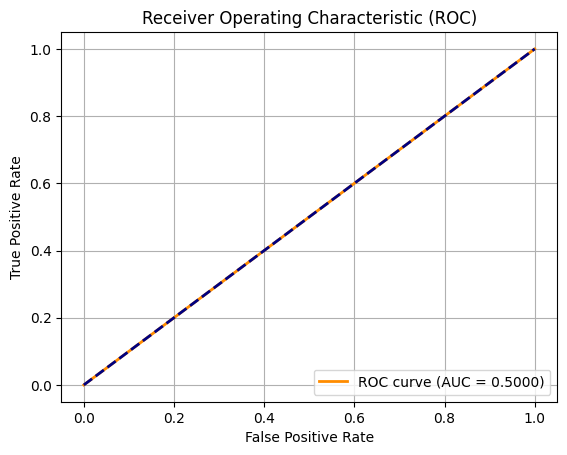

In [32]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **PREDICTION ON IMAGE**

In [ ]:
from PIL import Image


In [ ]:
path=r"/kaggle/input/flowers-dataset/train/daisy/100080576_f52e8ee070_n_jpg.rf.7304a94072d861e72591569a23415323.jpg"
path2=r"/kaggle/input/flowers-dataset/train/dandelion/10043234166_e6dd915111_n_jpg.rf.e9ab1864cbed23328490235f82110522.jpg"
path3=r"/kaggle/input/flowers-dataset/train/daisy/10300722094_28fa978807_n_jpg.rf.1661f5022c8b1e78ad7643d1e8fd8e42.jpg"

In [ ]:
image= Image.open(path)
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
   ])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


In [ ]:
# Perform inference
input_batch = input_batch.to(device) 

with torch.no_grad():
    output = model(input_batch)
    
predicted_index = output.argmax(1)
class_names = ['daisy', 'dandelion']  
predicted_class_name = class_names[predicted_index.item()]
print(f'The predicted class is: {predicted_class_name}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [ ]:
image= Image.open(path2)
input_tensor=preprocess(image)

In [ ]:
# Perform inference
input_batch = input_tensor.unsqueeze(0)  
input_batch = input_batch.to(device) 

with torch.no_grad():
    output = model(input_batch)
    
predicted_index = output.argmax(1)
class_names = ['daisy', 'dandelion']  
predicted_class_name = class_names[predicted_index.item()]
print(f'The predicted class is: {predicted_class_name}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()